In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_dep as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.bert_conf
encoding_type = 'absolute'
model_name = 'bert'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = generic.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5601101741454327 	 Validation loss: 0.3956543252629749 	 
  1%|          | 574/57400 [02:02<2:43:12,  5.80it/s]
Epoch 2 	 Training loss: 0.3782522003150152 	 Validation loss: 0.3488862287190001 	 
  2%|▏         | 1148/57400 [04:02<3:54:56,  3.99it/s]
Epoch 3 	 Training loss: 0.3416294242394926 	 Validation loss: 0.33087715860140526 	 
  3%|▎         | 1722/57400 [06:03<2:58:00,  5.21it/s]
Epoch 4 	 Training loss: 0.32170520507396305 	 Validation loss: 0.3203543475118734 	 
  4%|▍         | 2296/57400 [08:05<2:27:27,  6.23it/s]
Epoch 5 	 Training loss: 0.3073114344155747 	 Validation loss: 0.31456452810158164 	 
  5%|▌         | 2870/57400 [10:05<2:48:33,  5.39it/s]
Epoch 6 	 Training loss: 0.2941487618180102 	 Validation loss: 0.31053384103007237 	 
  6%|▌         | 3444/57400 [12:07<2:46:40,  5.40it/s]
Epoch 7 	 Training loss: 0.2809572454009737 	 Validation loss: 0.3046503756511009 	 
  7%|▋         | 4018/57400 [14:09<2:31:27,  5.87it/s]
Epoch 8 	 Trainin

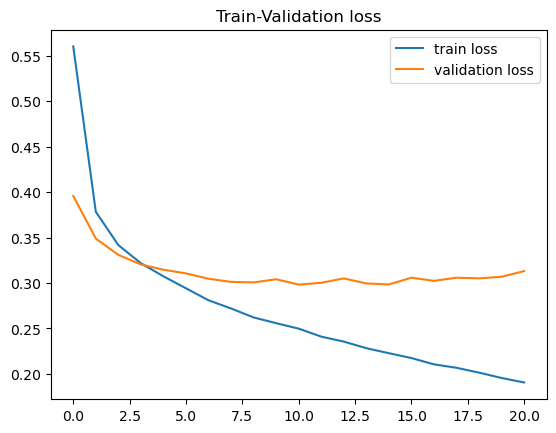

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8425, 'male': 0.8723958333333334, 'average': 0.8574479166666666}
precision {'female': 0.8730569948186528, 'male': 0.8417085427135679, 'average': 0.8573827687661104}
f1 {'female': 0.8575063613231553, 'male': 0.8567774936061381, 'average': 0.8571419274646467}
accuracy 0.8571428571428571


Evaluación en el conjunto el conjunto to
recall {'female': 0.6456692913385826, 'male': 0.7031630170316302, 'average': 0.6744161541851064}
precision {'female': 0.6684782608695652, 'male': 0.6816037735849056, 'average': 0.6750410172272354}
f1 {'female': 0.6568758344459278, 'male': 0.6922155688622755, 'average': 0.6745457016541017}
accuracy 0.6755050505050505


Evaluación en el conjunto el conjunto as
recall {'female': 0.660377358490566, 'male': 0.7070707070707071, 'average': 0.6837240327806365}
precision {'female': 0.6786703601108033, 'male': 0.6896551724137931, 'average': 0.6841627662622982}
f1 {'female': 0.669398907103825, 'male': 0.69825

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5833294115934637 	 Validation loss: 0.42211927094701995 	 
  1%|          | 574/57400 [01:52<2:30:27,  6.29it/s]
Epoch 2 	 Training loss: 0.3897554215030803 	 Validation loss: 0.35333617006318047 	 
  2%|▏         | 1148/57400 [03:46<2:37:10,  5.97it/s]
Epoch 3 	 Training loss: 0.3481210269527153 	 Validation loss: 0.3357114016504611 	 
  3%|▎         | 1722/57400 [05:39<2:28:22,  6.25it/s]
Epoch 4 	 Training loss: 0.3262943387394998 	 Validation loss: 0.32745026405585015 	 
  4%|▍         | 2296/57400 [07:33<2:35:57,  5.89it/s]
Epoch 5 	 Training loss: 0.31017125366768356 	 Validation loss: 0.3174234573113716 	 
  5%|▌         | 2870/57400 [09:28<2:52:39,  5.26it/s]
Epoch 6 	 Training loss: 0.2973186756623747 	 Validation loss: 0.3131590023384256 	 
  6%|▌         | 3444/57400 [11:20<2:38:04,  5.69it/s]
Epoch 7 	 Training loss: 0.2874401159818164 	 Validation loss: 0.3076787409135851 	 
  7%|▋         | 4018/57400 [13:13<2:53:33,  5.13it/s]
Epoch 8 	 Trainin

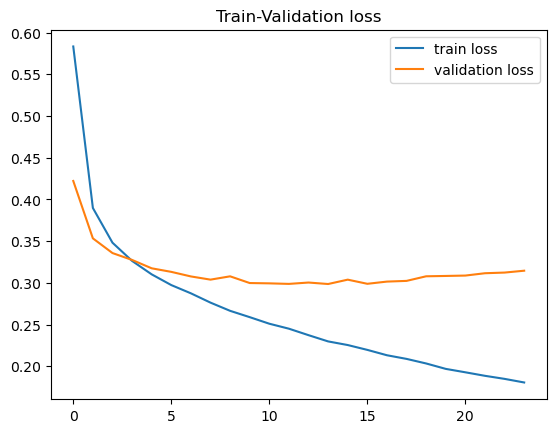

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p =train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [20]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8275, 'male': 0.8802083333333334, 'average': 0.8538541666666667}
precision {'female': 0.8779840848806366, 'male': 0.8304668304668305, 'average': 0.8542254576737336}
f1 {'female': 0.851994851994852, 'male': 0.854614412136536, 'average': 0.8533046320656941}
accuracy 0.8533163265306123


Evaluación en el conjunto el conjunto to
recall {'female': 0.6509186351706037, 'male': 0.7104622871046229, 'average': 0.6806904611376132}
precision {'female': 0.6757493188010899, 'male': 0.6870588235294117, 'average': 0.6814040711652508}
f1 {'female': 0.6631016042780747, 'male': 0.6985645933014354, 'average': 0.6808330987897551}
accuracy 0.6818181818181818


Evaluación en el conjunto el conjunto as
recall {'female': 0.6576819407008087, 'male': 0.7146464646464646, 'average': 0.6861642026736366}
precision {'female': 0.6834733893557423, 'male': 0.6902439024390243, 'average': 0.6868586458973833}
f1 {'female': 0.6703296703296703, 'male': 0.70223

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5756912175890461 	 Validation loss: 0.4103694694527125 	 
  1%|          | 574/57400 [01:53<2:35:45,  6.08it/s]
Epoch 2 	 Training loss: 0.3846720315853478 	 Validation loss: 0.35273053787522396 	 
  2%|▏         | 1148/57400 [03:45<2:53:41,  5.40it/s]
Epoch 3 	 Training loss: 0.3473706475689436 	 Validation loss: 0.3338221053955919 	 
  3%|▎         | 1722/57400 [05:39<2:25:40,  6.37it/s]
Epoch 4 	 Training loss: 0.32583987936117925 	 Validation loss: 0.32337835380586527 	 
  4%|▍         | 2296/57400 [07:33<2:31:33,  6.06it/s]
Epoch 5 	 Training loss: 0.3110754575048174 	 Validation loss: 0.3199656863333815 	 
  5%|▌         | 2870/57400 [09:27<2:51:44,  5.29it/s]
Epoch 6 	 Training loss: 0.29725912927231307 	 Validation loss: 0.3120885453486847 	 
  6%|▌         | 3444/57400 [11:20<2:54:27,  5.15it/s]
Epoch 7 	 Training loss: 0.28611134335346755 	 Validation loss: 0.3100658715781519 	 
  7%|▋         | 4018/57400 [13:13<2:44:32,  5.41it/s]
Epoch 8 	 Traini

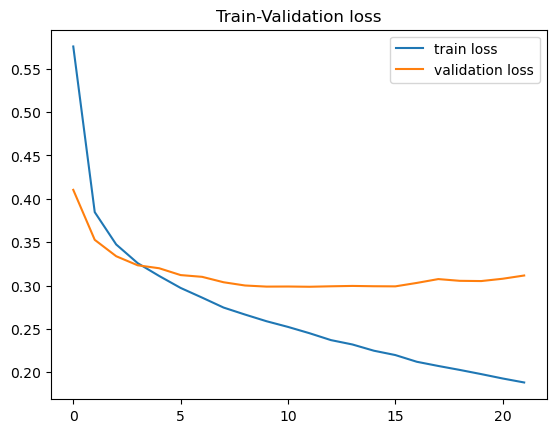

In [21]:
model =st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [22]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.83, 'male': 0.8671875, 'average': 0.84859375}
precision {'female': 0.8668407310704961, 'male': 0.830423940149626, 'average': 0.848632335610061}
f1 {'female': 0.8480204342273308, 'male': 0.848407643312102, 'average': 0.8482140387697163}
accuracy 0.8482142857142857


Evaluación en el conjunto el conjunto to
recall {'female': 0.6404199475065617, 'male': 0.7104622871046229, 'average': 0.6754411173055923}
precision {'female': 0.6721763085399449, 'male': 0.6806526806526807, 'average': 0.6764144945963129}
f1 {'female': 0.6559139784946236, 'male': 0.6952380952380952, 'average': 0.6755760368663595}
accuracy 0.6767676767676768


Evaluación en el conjunto el conjunto as
recall {'female': 0.6630727762803235, 'male': 0.7070707070707071, 'average': 0.6850717416755152}
precision {'female': 0.6795580110497238, 'male': 0.691358024691358, 'average': 0.685458017870541}
f1 {'female': 0.6712141882673943, 'male': 0.6991260923845193, 'average'

Resultados finales

In [23]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8528868661000191
f1 etiqueta male: 0.853266516351592
f1 etiqueta female:  0.852507215848446


TO
Resultado global f1: 0.6769849457700721
f1 etiqueta male: 0.6953394191339354
f1 etiqueta female:  0.6586304724062088


AS
Resultado global f1: 0.6850927454659219
f1 etiqueta male: 0.6998712356982141
f1 etiqueta female:  0.6703142552336299


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.8532986111111112
recall etiqueta male: 0.873263888888889
recall etiqueta female:  0.8333333333333334


TO
Resultado global recall: 0.6768492442094373
recall etiqueta male: 0.708029197080292
recall etiqueta female:  0.6456692913385826


AS
Resultado global recall: 0.6849866590432628
recall etiqueta male: 0.7095959595959596
recall etiqueta female:  0.660377358490566


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8534135206833017
precision etiqueta male: 0.8341997711100081
precision etiqueta female:  0.872627

# TO

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6972577619635685 	 Validation loss: 0.6926588719174013 	 
  1%|          | 574/57400 [11:05<13:18:06,  1.19it/s]
Epoch 2 	 Training loss: 0.6952022674399386 	 Validation loss: 0.6937106797250651 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [20:24<13:24:10,  1.17it/s]
Epoch 3 	 Training loss: 0.6944009952428865 	 Validation loss: 0.69380106562275 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [31:45<19:18:10,  1.25s/it]
Epoch 4 	 Training loss: 0.6936812403933097 	 Validation loss: 0.6922060311850855 	 
  4%|▍         | 2296/57400 [50:49<28:58:50,  1.89s/it]
Epoch 5 	 Training loss: 0.6935653896281944 	 Validation loss: 0.6937120496216467 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [1:09:27<10:52:24,  1.39it/s]
Epoch 6 	 Training loss: 0.693402545688875 	 Validation loss: 0.692757724705389 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [1:18:40<11:03:28,  1.36it/s]
Epoch 7 	 Training loss: 0.693522913946

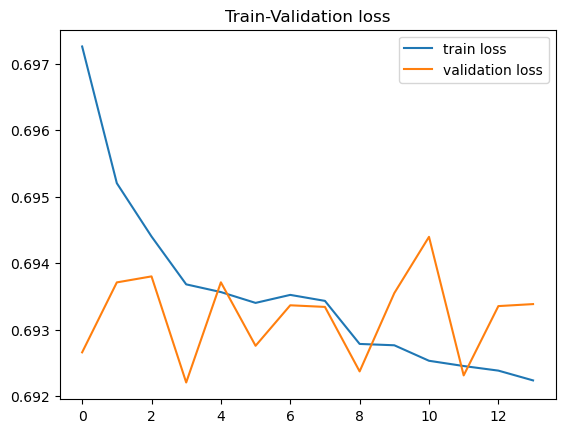

In [26]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [17]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.815, 'male': 0.15885416666666666, 'average': 0.4869270833333333}
precision {'female': 0.50231124807396, 'male': 0.45185185185185184, 'average': 0.4770815499629059}
f1 {'female': 0.6215443279313632, 'male': 0.23506743737957608, 'average': 0.42830588265546965}
accuracy 0.49362244897959184


Evaluación en el conjunto el conjunto to
recall {'female': 0.8372703412073491, 'male': 0.17761557177615572, 'average': 0.5074429564917524}
precision {'female': 0.4855403348554033, 'male': 0.5407407407407407, 'average': 0.513140537798072}
f1 {'female': 0.6146435452793834, 'male': 0.2673992673992674, 'average': 0.4410214063393254}
accuracy 0.494949494949495


Evaluación en el conjunto el conjunto as
recall {'female': 0.8463611859838275, 'male': 0.13383838383838384, 'average': 0.4900997849111057}
precision {'female': 0.4779299847792998, 'male': 0.4818181818181818, 'average': 0.4798740832987408}
f1 {'female': 0.6108949416342412, 'male': 0.2

In [18]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to2'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6974025089358619 	 Validation loss: 0.6939923793582593 	 
  1%|          | 574/57400 [08:49<10:52:35,  1.45it/s]
Epoch 2 	 Training loss: 0.6948611277321074 	 Validation loss: 0.6942886457604877 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [18:33<11:55:21,  1.31it/s]
Epoch 3 	 Training loss: 0.6944230125133168 	 Validation loss: 0.6924078242253449 	 
  3%|▎         | 1722/57400 [28:20<12:23:25,  1.25it/s]
Epoch 4 	 Training loss: 0.6938020164335231 	 Validation loss: 0.6925201123043642 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [37:08<10:17:48,  1.49it/s]
Epoch 5 	 Training loss: 0.6938494622499686 	 Validation loss: 0.6929868772878485 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [46:43<12:06:16,  1.25it/s]
Epoch 6 	 Training loss: 0.6937131350048743 	 Validation loss: 0.6933662861080493 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [55:37<13:41:09,  1.10it/s]
Epoch 7 	 Training loss: 0.693568740987

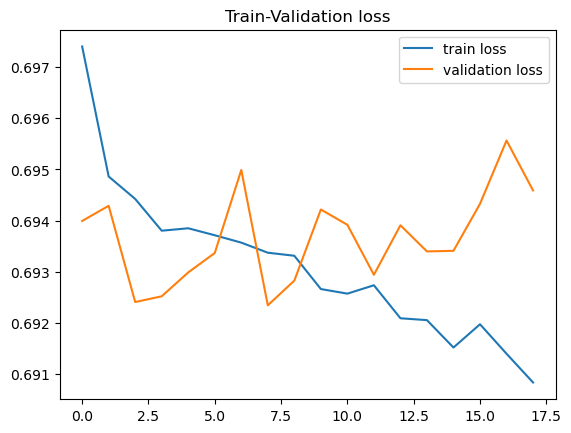

In [29]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.7325, 'male': 0.359375, 'average': 0.5459375}
precision {'female': 0.5435992578849722, 'male': 0.563265306122449, 'average': 0.5534322820037105}
f1 {'female': 0.6240681576144835, 'male': 0.43879173290937995, 'average': 0.5314299452619318}
accuracy 0.5497448979591837


Evaluación en el conjunto el conjunto to
recall {'female': 0.6404199475065617, 'male': 0.40145985401459855, 'average': 0.5209399007605802}
precision {'female': 0.49795918367346936, 'male': 0.5463576158940397, 'average': 0.5221583997837546}
f1 {'female': 0.5602755453501722, 'male': 0.4628330995792426, 'average': 0.5115543224647074}
accuracy 0.5164141414141414


Evaluación en el conjunto el conjunto as
recall {'female': 0.7331536388140162, 'male': 0.398989898989899, 'average': 0.5660717689019577}
precision {'female': 0.5333333333333333, 'male': 0.6147859922178989, 'average': 0.574059662775616}
f1 {'female': 0.6174801362088536, 'male': 0.4839203675344564, 'ave

In [21]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to3'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6987314100672559 	 Validation loss: 0.6930435461513067 	 
  1%|          | 574/57400 [01:51<2:34:41,  6.12it/s]
Epoch 2 	 Training loss: 0.6951297430211243 	 Validation loss: 0.6940036092774343 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:36<2:37:56,  5.94it/s]
Epoch 3 	 Training loss: 0.6937420390001158 	 Validation loss: 0.6931579395876093 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:21<2:39:18,  5.83it/s]
Epoch 4 	 Training loss: 0.6939467015166731 	 Validation loss: 0.6934045037980807 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [07:07<2:37:42,  5.82it/s]
Epoch 5 	 Training loss: 0.6938061698596236 	 Validation loss: 0.693311319512836 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [08:53<2:59:15,  5.07it/s]
Epoch 6 	 Training loss: 0.6937376463247094 	 Validation loss: 0.6931161920903093 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [10:40<2:43:42,  5.49it/s]
Epoch 7 	 Trainin

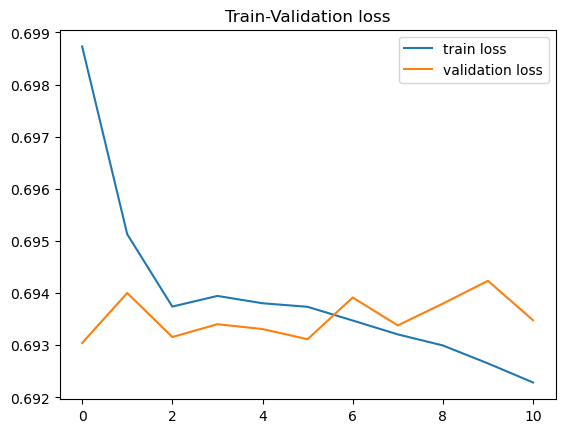

In [22]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [23]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.425, 'male': 0.5208333333333334, 'average': 0.47291666666666665}
precision {'female': 0.480225988700565, 'male': 0.46511627906976744, 'average': 0.47267113388516624}
f1 {'female': 0.4509283819628647, 'male': 0.4914004914004914, 'average': 0.47116443668167807}
accuracy 0.4719387755102041


Evaluación en el conjunto el conjunto to
recall {'female': 0.5170603674540682, 'male': 0.48418491484184917, 'average': 0.5006226411479587}
precision {'female': 0.48166259168704156, 'male': 0.5195822454308094, 'average': 0.5006224185589255}
f1 {'female': 0.4987341772151899, 'male': 0.5012594458438288, 'average': 0.49999681152950937}
accuracy 0.5


Evaluación en el conjunto el conjunto as
recall {'female': 0.5040431266846361, 'male': 0.4772727272727273, 'average': 0.4906579269786817}
precision {'female': 0.4746192893401015, 'male': 0.5067024128686327, 'average': 0.4906608511043671}
f1 {'female': 0.4888888888888889, 'male': 0.4915474642392

Resultados finales

In [25]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4769667548663598
f1 etiqueta male: 0.3884198872298158
f1 etiqueta female:  0.5655136225029038


TO
Resultado global f1: 0.4841908467778474
f1 etiqueta male: 0.4104972709407796
f1 etiqueta female:  0.5578844226149151


AS
Resultado global f1: 0.4837029940856028
f1 etiqueta male: 0.3949846659272111
f1 etiqueta female:  0.5724213222439946


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5019270833333334
recall etiqueta male: 0.3463541666666667
recall etiqueta female:  0.6575


TO
Resultado global recall: 0.5096684994667637
recall etiqueta male: 0.35442011354420117
recall etiqueta female:  0.6649168853893264


AS
Resultado global recall: 0.5156098269305817
recall etiqueta male: 0.3367003367003367
recall etiqueta female:  0.6945193171608266


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5010616552839275
precision etiqueta male: 0.4934111456813561
precision etiqueta female:  0.508712164886

# AS

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as1'


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6977516905978997 	 Validation loss: 0.6944713754169012 	 
  1%|          | 574/57400 [01:42<2:39:20,  5.94it/s]
Epoch 2 	 Training loss: 0.6961226963830742 	 Validation loss: 0.6937216045492787 	 
  2%|▏         | 1148/57400 [03:25<2:39:22,  5.88it/s]
Epoch 3 	 Training loss: 0.6943939546259438 	 Validation loss: 0.691843321767904 	 
  3%|▎         | 1722/57400 [05:09<2:46:01,  5.59it/s]
Epoch 4 	 Training loss: 0.6930701926817877 	 Validation loss: 0.69082785763983 	 
  4%|▍         | 2296/57400 [06:53<2:37:37,  5.83it/s]
Epoch 5 	 Training loss: 0.6915700560247441 	 Validation loss: 0.6908531492039308 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:37<2:23:22,  6.34it/s]
Epoch 6 	 Training loss: 0.689821185758305 	 Validation loss: 0.6917496374097921 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:22<2:14:44,  6.67it/s]
Epoch 7 	 Training loss: 0.6881492405818315 	 Validation loss: 0.6907595941575907 	 
  7%|▋         | 4018/

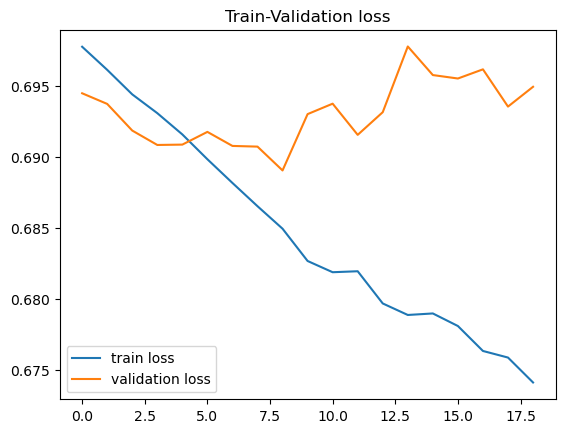

In [38]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [17]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.6425, 'male': 0.7135416666666666, 'average': 0.6780208333333333}
precision {'female': 0.7002724795640327, 'male': 0.657074340527578, 'average': 0.6786734100458054}
f1 {'female': 0.6701434159061278, 'male': 0.6841448189762797, 'average': 0.6771441174412037}
accuracy 0.6772959183673469


Evaluación en el conjunto el conjunto to
recall {'female': 0.6377952755905512, 'male': 0.7201946472019465, 'average': 0.6789949613962488}
precision {'female': 0.6787709497206704, 'male': 0.6820276497695853, 'average': 0.6803992997451278}
f1 {'female': 0.6576454668470907, 'male': 0.7005917159763314, 'average': 0.679118591411711}
accuracy 0.6805555555555556


Evaluación en el conjunto el conjunto as
recall {'female': 0.7816711590296496, 'male': 0.7626262626262627, 'average': 0.7721487108279561}
precision {'female': 0.7552083333333334, 'male': 0.7885117493472585, 'average': 0.771860041340296}
f1 {'female': 0.7682119205298014, 'male': 0.775353

In [18]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as2'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6958700487007248 	 Validation loss: 0.6934869885444641 	 
  1%|          | 574/57400 [01:42<2:36:22,  6.06it/s]
Epoch 2 	 Training loss: 0.694702831814098 	 Validation loss: 0.6933638372663724 	 
  2%|▏         | 1148/57400 [03:24<2:35:34,  6.03it/s]
Epoch 3 	 Training loss: 0.6924657719891246 	 Validation loss: 0.6925459786997004 	 
  3%|▎         | 1722/57400 [05:06<2:34:54,  5.99it/s]
Epoch 4 	 Training loss: 0.6906053790439712 	 Validation loss: 0.6895620135937707 	 
  4%|▍         | 2296/57400 [06:49<2:30:34,  6.10it/s]
Epoch 5 	 Training loss: 0.6895385501899786 	 Validation loss: 0.6911385271508815 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:31<2:26:00,  6.22it/s]
Epoch 6 	 Training loss: 0.6874976680461538 	 Validation loss: 0.689375405594454 	 
  6%|▌         | 3444/57400 [10:14<2:38:28,  5.67it/s]
Epoch 7 	 Training loss: 0.6850401515121659 	 Validation loss: 0.6892269041578648 	 
  7%|▋         | 4018/57400 [11:56<2:35:03,  5.74

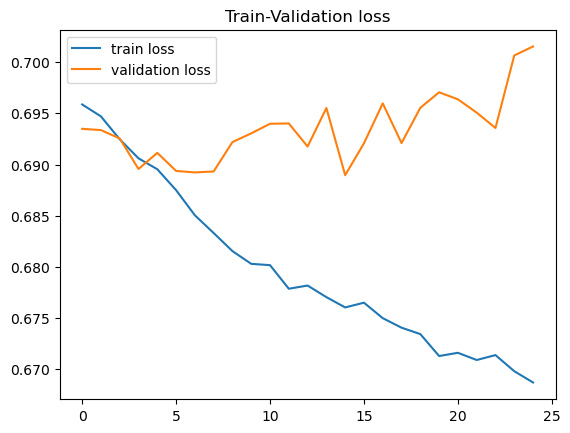

In [41]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.6725, 'male': 0.625, 'average': 0.6487499999999999}
precision {'female': 0.6513317191283293, 'male': 0.6469002695417789, 'average': 0.6491159943350542}
f1 {'female': 0.6617466174661747, 'male': 0.6357615894039734, 'average': 0.6487541034350741}
accuracy 0.6492346938775511


Evaluación en el conjunto el conjunto to
recall {'female': 0.6981627296587927, 'male': 0.7177615571776156, 'average': 0.7079621434182042}
precision {'female': 0.6963350785340314, 'male': 0.7195121951219512, 'average': 0.7079236368279913}
f1 {'female': 0.6972477064220184, 'male': 0.7186358099878197, 'average': 0.707941758204919}
accuracy 0.7083333333333334


Evaluación en el conjunto el conjunto as
recall {'female': 0.8301886792452831, 'male': 0.7727272727272727, 'average': 0.8014579759862779}
precision {'female': 0.7738693467336684, 'male': 0.8292682926829268, 'average': 0.8015688197082975}
f1 {'female': 0.8010403120936281, 'male': 0.7999999999999999,

In [20]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as3'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6966286200887235 	 Validation loss: 0.695405727725918 	 
  1%|          | 574/57400 [01:57<2:36:47,  6.04it/s]
Epoch 2 	 Training loss: 0.6938761226599225 	 Validation loss: 0.6944383261567455 	 
  2%|▏         | 1148/57400 [03:56<2:45:25,  5.67it/s]
Epoch 3 	 Training loss: 0.6928418733517052 	 Validation loss: 0.6924417412887185 	 
  3%|▎         | 1722/57400 [05:55<2:31:05,  6.14it/s]
Epoch 4 	 Training loss: 0.6917376471521132 	 Validation loss: 0.6938355514558695 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:55<2:39:01,  5.77it/s]
Epoch 5 	 Training loss: 0.6904600198260583 	 Validation loss: 0.6927163792868792 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [09:54<2:32:22,  5.96it/s]
Epoch 6 	 Training loss: 0.6894351923091901 	 Validation loss: 0.6918841327651072 	 
  6%|▌         | 3444/57400 [11:54<2:31:40,  5.93it/s]
Epoch 7 	 Training loss: 0.6879507455883956 	 Validation loss: 0.6931137149616823 	 

1 epoch without im

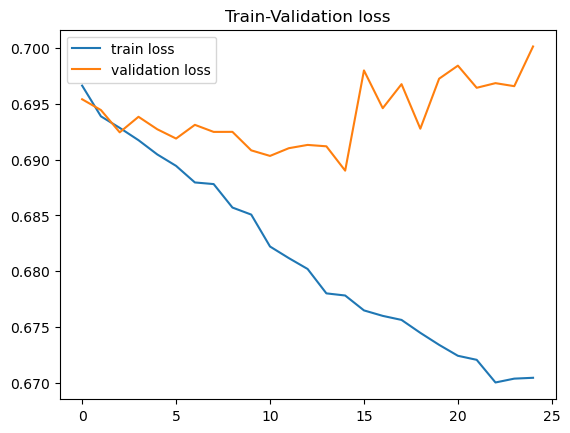

In [22]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [23]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.7225, 'male': 0.59375, 'average': 0.6581250000000001}
precision {'female': 0.6494382022471911, 'male': 0.672566371681416, 'average': 0.6610022869643035}
f1 {'female': 0.6840236686390533, 'male': 0.6307053941908713, 'average': 0.6573645314149623}
accuracy 0.6594387755102041


Evaluación en el conjunto el conjunto to
recall {'female': 0.7139107611548556, 'male': 0.6423357664233577, 'average': 0.6781232637891066}
precision {'female': 0.649164677804296, 'male': 0.707774798927614, 'average': 0.678469738365955}
f1 {'female': 0.6800000000000002, 'male': 0.673469387755102, 'average': 0.6767346938775511}
accuracy 0.6767676767676768


Evaluación en el conjunto el conjunto as
recall {'female': 0.8247978436657682, 'male': 0.648989898989899, 'average': 0.7368938713278337}
precision {'female': 0.6876404494382022, 'male': 0.7981366459627329, 'average': 0.7428885477004676}
f1 {'female': 0.7500000000000001, 'male': 0.7158774373259054, 'a

Resultados finales

In [24]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.66108758409708
f1 etiqueta male: 0.6502039341903748
f1 etiqueta female:  0.6719712340037852


TO
Resultado global f1: 0.687931681164727
f1 etiqueta male: 0.6975656379064177
f1 etiqueta female:  0.6782977244230364


AS
Resultado global f1: 0.7684137811062328
f1 etiqueta male: 0.7637434846713224
f1 etiqueta female:  0.7730840775411432


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.6616319444444444
recall etiqueta male: 0.6440972222222222
recall etiqueta female:  0.6791666666666667


TO
Resultado global recall: 0.6883601228678532
recall etiqueta male: 0.6934306569343066
recall etiqueta female:  0.6832895888013998


AS
Resultado global recall: 0.7701668527140225
recall etiqueta male: 0.7281144781144782
recall etiqueta female:  0.812219227313567


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.662930563781721
precision etiqueta male: 0.6588469939169243
precision etiqueta female:  0.667014